# ADAPT VQE

> The **Adaptive Derivative-Assembled Pseudo-Trotter Variational Quantum Eigensolver (ADAPT-VQE)** [[1](#ADAPT-VQE)] is a variational hybrid algorithm, which constitutes an extension of the Variational Quantum Eigensolver (VQE) framework [[2](#VQE)], that constructs problem-specific ansätze in a systematic and adaptive manner. Instead of relying on a fixed, heuristic circuit structure, ADAPT-VQE iteratively grows the state ansatz by selecting operators from a predefined pool based on their energy gradients with respect to the current variational state. At each iteration, the operator that yields the largest energy reduction is appended to the circuit and its parameters are reoptimized. This adaptive procedure significantly reducing the number of variational parameter and circuit depth, making ADAPT-VQE particularly well suited for near-term quantum hardware.
>
> The algorithm treats the following problem:
>
> - **Input:** System Hamiltonian $H$, reference state $| \Psi_{\text{ref}}\rangle$ and an operator pool of anti-Hermitian operators ${\cal O} =\{O_1,\dots,O_M\}$.
> - **Output:** Approximation of the ground state and energy.
>
> **Complexity:** The complexity of the algorithm depends on the chosen operator pool and classical optimization scheme. The total cost incorporates the two main components of the algorithm, (i) evaluating the energy gradient, and (ii) re-optimization of the current state-ansats (corresponds to the standard VQE optimization). As a result, at each iteration step the cost is a sum of two terms, corresponding to the two algorithm components:
$$\text{Cost}\approx \sum_{k = 1}^K (M \cdot C_G(n)+ N_{\text{opt}^{(k)}}\cdot C_E(n))~~,$$ where $n$ is the number of qubits, $K$ is the total number of iterations, $C_G(n)$ is the cost to estimate a single operator gradient, $N_{\text{opt}}^{(k)}$ is the number of optimizer steps at iteration $k$, and $C_E(n)$ is the cost to estimate the energy once. The major overhead generally comes from the evaluation of the elements of the energy gradient by repeated measurements of different observables. 
> 
> ---
>
> **Keywords:**  Variational quantum algorithm, Chemistry, Optimization

## Overview

The following notebook begins with a theoretical explanation of the algorithm. We then consider an explicit example, consisting of a system of four qubits. The ADAPT-VQE algorithm is employed to evaluate the ground state energy and state. Following, the results are compared to the results obtained by the standard VQE algorithm. The notebook concludes by a short summary and analysis of the algorithm and results.

## Algorithm steps
The algorithm builds and constructs the ansatz iteratively, one operator at a time, including only the most significant operators. This approach builds a minimal, problem-specific ansatz, avoiding unnecessary parameters and allowing systematic improvement of the accuracy. Similarly to VQE, the algorithms essentially reduce the circuit depth at the expense of measurements. 

Initially, we define an operator pool ${\cal O}=\{O_1,O_2,\cdots,O_M\}$, containing a collection of anti-Hermitian operators that are employed in the ansatz construction.

We then follow the following procedure:
1. Initialize the qubits to the reference state, $| \Psi_{\text{ref}}\rangle$, and define the initial iterative state as $| \psi^{(0)}\rangle = | \Psi_{\text{ref}} \rangle$.
2. Prepare a trial quantum state with the current ansatz, denoted by $|\psi^{(k)}\rangle$, where $k=0,1,\dots$ corresponds to the iteration step number (initially set to zero).
3. Measure the commutator of the Hamiltonian with the operators of $\cal{O}$. The expectation value corresponds to the partial derivative of the energy (in the $k$ iteration step) with respect to the coefficient of $O_j$: $$\frac{\partial E^{(k+1)}}{\partial \theta_j}\bigg |_{\theta_j=0} = \langle\psi^{(k)}|\partial_{\theta_i}e^{-\theta_i O_j} H e^{O_j \theta_j}|\psi^{(l)}\rangle {\bigg |}_{\theta_j = 0}+ \langle\psi^{(k)}|e^{-\theta_j O_j} H \partial_{\theta_j}e^{O_j \theta_j}|\psi^{(k)}\rangle {\bigg |}_{\theta_j = 0}$$ $$= {{\langle \psi^{(k)}|  [H, O_j] |\psi^{(k)}\rangle}}~.$$ Hence, the measured commutation relations, provides the gradiant $\nabla_\vec{\theta} E$, where $\vec{\theta} = \{\theta_1,\dots,\theta_k\}^T~~.$ 
4. If the magnitude of the gradient vector is below a certain threshold, stop. Otherwise, identify the operator with the largest gradient, and add it to the left end of the ansatz, with a new variational parameter. If $A_k\in \{O_i\}$ is an operator with the largest gradient on the step $k$, the update rule is given by $$|\psi^{(k+1)} \rangle = e^{\theta_k A_k} |\psi^{(k)}\rangle~~.$$  Note, that the added operator still remains in the operator pool, therefore may be added again later on.
5. Conduct a VQE experiment to re-optimize all the ansatz parameters, $\{\theta_1,\dots,\theta_k\}$.
6. Go back to step 3 and take $k\rightarrow k+1$.


The final optimized ansatz is of the form $$| \psi^{\text{ADAPT}}(\vec{\theta}) \rangle = \Pi_{n=1}^{K} e^{\theta_k A_k}|\psi_{\text{ref}}\rangle~~,$$ where $K$ is the total number of iterations.

Note that when multiple quantum computers are available, the preparation of the trial state and measurement of the commutation relations with the Hamiltonian can be performed in parallel, substantially reducing the runtime.

## Implementation of ADPT-VQE with Classiq

We consider a simple example, consisting of a four-qubit system. The Hamiltonian and operator pool are defined in terms of the [SparsePauliOp](https://docs.classiq.io/latest/qmod-reference/api-reference/classical-types/?h=sparsepauliop#classiq.qmod.builtins.structs.SparsePauliOp) data structure, allowing for rapid and efficient algebraic computations.
For implementation convenience, we consider an operator pool of Hermitian operators (instead of anti-Hermitian as in the theoretical derivation). In this case, the ansatz stat is of the form 
$$| \psi^{\text{ADAPT}}(\vec{\theta}) \rangle = \Pi_{k=1}^{K} e^{-i\theta_k A_k}|\psi_{\text{ref}}\rangle~~,$$
leading to the relation
$$\frac{\partial E^{(k+1)}}{\partial \theta_j}\bigg |_{\theta_j=0} = -i{{\langle \psi^{(k)}|  [H, O_j] |\psi^{(k)}\rangle}}~~.$$

We begin by uploading software packages and utility functions

In [1]:
from functools import reduce
from operator import add, mul
from typing import Final, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

from classiq import *

### Utility functions
We employ utility functions form the [ADAPT-QAOA notebook](https://github.com/Classiq/classiq-library/blob/main/applications/optimization/adapt_qaoa/adapt_qaoa.ipynb), used to efficiently compute the commutation of Pauli strings with the `SparsePauilOp` data structure. These are used in the computation of $\langle \psi^{(k)} | [H, O_j] | \psi^{(k)}\rangle$.

The functions perform the following tasks:
- `sorted_pauli_term` sorts Pauli terms according to the qubit's index.
- `commutator` receives two `SparsePauilOp`s and returns their commutator as a `SparsePauilOp`.
- `normalize_pauli_term` removes redundant Pauli identity operators, allowing for comparison and addition of two `SparsePauilOp`s.
- `collect_pauli_terms` adds up the coefficients of identical Pauli strings.

In [2]:
# multiplication table of two Pauli matrices
# weight (imaginary), pauli_c = pauli_a * pauli_b
pauli_mult_table: list[list[Tuple[int, int]]] = [
    [(+0, Pauli.I), (+0, Pauli.X), (+0, Pauli.Y), (+0, Pauli.Z)],
    [(+0, Pauli.X), (+0, Pauli.I), (+1, Pauli.Z), (-1, Pauli.Y)],
    [(+0, Pauli.Y), (-1, Pauli.Z), (+0, Pauli.I), (+1, Pauli.X)],
    [(+0, Pauli.Z), (+1, Pauli.Y), (-1, Pauli.X), (+0, Pauli.I)],
]


def sorted_pauli_term(term: SparsePauliTerm) -> SparsePauliTerm:
    """
    Sort Pauli terms according to the qubit's index, e.g.,
    Pauli.X(2)*Pauli.Z(7)*Pauli.X(4) ==> Pauli.X(2)*Pauli.X(4)*Pauli.Z(7)
    """
    sorted_paulis = sorted(term.paulis, key=lambda p: p.index)
    return SparsePauliTerm(sorted_paulis, term.coefficient)


def commutator(ha: SparsePauliOp, hb: SparsePauliOp) -> SparsePauliOp:
    """
    Compute the commutator [ha, hb] = ha*hb - hb*ha, where ha and hb are SparsePauliOp objects.
    Returns a SparsePauliOp representing the commutator.
    """
    n = max(ha.num_qubits, hb.num_qubits)
    commutation = SparsePauliOp([], n)

    for sp_term_a in ha.terms:
        for sp_term_b in hb.terms:
            parity = 1
            coefficient = 1.0
            msp = {p.index: p.pauli for p in sp_term_a.paulis}
            for p in sp_term_b.paulis:
                pauli_a = msp.get(p.index, Pauli.I)
                pauli_b = p.pauli
                weight, pauli = pauli_mult_table[pauli_a][pauli_b]
                if weight != 0:
                    parity = -parity
                    coefficient *= weight * 1j
                msp[p.index] = pauli
            # reconstruct pauli_string
            if parity != 1:
                # consider filtering identity terms, making sure the term is not empty
                pauli_term = (reduce(mul, (p(idx) for idx, p in msp.items()))).terms[0]
                pauli_term.coefficient = (
                    sp_term_a.coefficient * sp_term_b.coefficient * coefficient * 2
                )
                commutation.terms.append(pauli_term)
    return commutation


def normalize_pauli_term(spt: SparsePauliTerm, num_qubits=-1) -> SparsePauliTerm:
    """
    Remove redundant Pauli.I operators from a Pauli string
    making "normalized" strings comparable
    if num_qubits is set, an optional Pauli.I is added to ensure the length
    """
    if not spt.paulis:
        return spt

    npt = sorted_pauli_term(spt)

    paulis = []
    max_index = max_identity_index = -1
    if num_qubits > 0:
        max_identity_index = num_qubits - 1
    for ip in npt.paulis:
        if ip.pauli != Pauli.I:
            paulis.append(ip)
            max_index = max(max_index, int(ip.index))
        else:
            max_identity_index = max(max_identity_index, int(ip.index))

    if max_identity_index > max_index:
        paulis.append(IndexedPauli(Pauli.I, max_identity_index))

    npt.paulis = paulis
    return npt


def collect_pauli_terms(spo: SparsePauliOp) -> SparsePauliOp:
    """
    Collect the coefficient of identical Pauli strings
    for example: 1.5*"IXZI"-0.3*"IXXZ"+0.4*"IXZI", would result, in:
    1.9*"IXZI"-0.3*"IXXZ".
    The function correctly ignores "I" when comparing strings, and sets the correct `num_qubits`
    terms with abs(coefficient)<TOLERANCE are dropped
    """
    TOLERANCE: Final[float] = 1e-10
    pauliterms = {}
    for term in spo.terms:
        npt = normalize_pauli_term(term, spo.num_qubits)
        key = tuple((ip.pauli, int(ip.index)) for ip in npt.paulis)
        pauliterms[key] = pauliterms.get(key, 0) + term.coefficient

    def single_qubit_op(pair: tuple[int, int]) -> SparsePauliOp:
        p_int, idx = pair
        term = SparsePauliTerm([IndexedPauli(Pauli(p_int), idx)], 1.0)
        return SparsePauliOp([term], num_qubits=idx + 1)

    paulistrings = []
    for key, coeff in pauliterms.items():
        if np.abs(coeff) < TOLERANCE:
            continue
        key_op = reduce(mul, (single_qubit_op(pair) for pair in key))
        paulistrings.append(coeff * key_op)

    if not paulistrings:
        return SparsePauliOp([], spo.num_qubits)

    # Sum all strings
    return reduce(add, paulistrings)

Next, we define the `grad_energy` function, which receives an operator, `op`, and Hamiltonian, `hamiltonian`, as `SpasePauilOp`s, and evaluates the absolute value of the expectation value of the commutation relation $\nabla_{\vec{\theta}} E_j=i\langle\psi^{(k)}|[H,O_j] |\psi^{(k)}\rangle~~,$ with respect to an execution session `es` and optimization parameters `params`.

In [3]:
def grad_energy(
    op: SparsePauliOp,
    hamiltonian: SparsePauliOp,
    es: ExecutionSession,
    params: list[float],
) -> float:
    h_op_comm = -1j * commutator(hamiltonian, op)
    return es.estimate(h_op_comm, {"params": params}).value

### Defining the Example System and Operator Pool

In [4]:
# Hamiltonian
HAMILTONIAN = (
    -0.1 * Pauli.Z(0) * Pauli.Z(1)
    + 0.2 * Pauli.X(0)
    - 0.3 * Pauli.Z(1) * Pauli.Z(2)
    + 0.4 * Pauli.Z(1)
    - 0.1 * Pauli.Y(2) * Pauli.Z(3)
    + 0.2 * Pauli.Y(2)
    - 0.5 * Pauli.X(2) * Pauli.Z(3)
    + 0.2 * Pauli.Z(3)
    - 0.1 * Pauli.Y(1)
    + 0.3 * Pauli.I(0)
)

NUM_QUBITS = 4

# Operator pool
single_x_ops = [Pauli.X(i) for i in range(4)]
single_y_ops = [Pauli.Y(i) for i in range(4)]
single_z_ops = [Pauli.Z(i) for i in range(4)]
xx_ops = [Pauli.X(i) * Pauli.X(j) for i in range(4) for j in range(4) if i != j]

# op_pool = single_x_ops + single_y_ops + single_z_ops
op_pool = single_x_ops + single_y_ops


# Ground state energy
Hamiltonian_matrix = hamiltonian_to_matrix(HAMILTONIAN)
eigvals, eigvecs = np.linalg.eig(Hamiltonian_matrix)
ground_state_energy = np.real(np.min(eigvals))

In [5]:
print(f"Ground state energy: {ground_state_energy}")

Ground state energy: -1.189380715792109


### Main program



Before defining the ADAPT-VQE main function, we first define the `adapt_vqe_ansatz` function, which prepares the product state of phases, $|\psi^{\text{ADAPT}}(\vec{\theta})) \rangle = \Pi_{n=1}^{K} e^{-i\theta_k A_k}|\psi_{\text{ref}}\rangle$, defined by the optimization parameters, `thetas`, and the associated operators of the operator pool, $\cal O$.
The function builds the state, phase by phase, utilizing a helper function `adapt_layer`. 
The reference state is taken to be $$|\psi_{\text{ref}}\rangle=|0^n \rangle~~,$$ where $n=4$ is the number of qubits.

In [6]:
@qfunc
def adapt_layer(idx: int, theta: CReal, qba: QArray):
    suzuki_trotter(op_pool[idx], theta, 1, 1, qba)


@qfunc
def adapt_vqe_ansatz(
    thetas: CArray[CReal],
    ansatz_ops: List[int],
    qba: QArray,
):
    n = thetas.len
    for i in range(n):
        adapt_layer(ansatz_ops_indicies[i], thetas[i], qba)

Following the algorithm steps, the main ADAPT-VQE performs an iterative calculation, each time adding another phase to the ansatz, thereby increasing the ansatz length, `k`, (starting from $k=1$) until the gradient converges and satisfies $|\nabla E|/k <$`tol`. If the procedure does not converge, we limit the number of iterations by `MAX_ITERATIONS`.

Each iteration begins with a preparation of the ansatz state $\Pi_{k=1}^{K} e^{-i\theta_k A_k}|\psi_{\text{ref}}\rangle$ for the current $p$. The state preparation is performed by the first `main` quantum function, the quantum circuit is synthesized, and the optimization parameters are optimized by the `es` execution call and saved as a Python list in `params`. The `params` parameters, along with the operators represented by the associated operator indices stored in the `ansatz_ops`, completely define the ansatz state. 

Finally, the elements of the gradient, $\nabla_{\vec{\theta}}E$, are evaluated by the execution call using the `grad_energy` function. A convergence check is made; if the ansatz state converged or the number of iterations exceeds the limit, the iterative procedure is terminated; otherwise, the iteration cycle continues.  

In [7]:
# maximum number of iterations
MAX_ITERATIONS = 20

# stores the optimization parameters of the recent iteration
last_params = []

ansatz_ops_indicies: list[int] = []
# start with default parameter
ansatz_ops_indicies.append(0)

# stores the gradient norms
gradient_norms = []

# stores the minimal gradient element in each step
picked_derivatives = []

# ansatz state energy
energies = []

# gradient norm tolerance for stopping criterion
tol: Final[float] = 0.027

iteration = 0
while True:  # loop until gradient norm exceeds tolerance (break-ing out of the loop)
    iteration += 1
    # number of layers (initially=1)
    k = len(ansatz_ops_indicies)
    # trace and history for analysis and plotting
    cost_trace = []
    params_history = []

    @qfunc
    def main(params: CArray[CReal, k], v: Output[QArray[QBit, NUM_QUBITS]]):
        allocate(v)
        n = params.len
        # print(f"Building ansatz with {n} layers.")
        adapt_vqe_ansatz(params, ansatz_ops_indicies, v)

    qprog = synthesize(main)

    # write an equivalent qmod file
    write_qmod(main, name="adapt_vqe", decimal_precision=15, symbolic_only=False)

    # initial optimization parameters for the VQE re-optimization
    initial_params = np.linspace(0, 1, k).tolist()
    with ExecutionSession(qprog) as es:
        optimization_results = es.minimize(
            cost_function=HAMILTONIAN,  # Hamiltonian problem
            initial_params={"params": initial_params},
            max_iteration=100,
        )

    params = optimization_results[-1][1]["params"]
    last_params = params[:]  # copy for final execution

    energy = optimization_results[-1][0]
    energies.append(energy)

    ## Compute gradients of operator pool elements
    @qfunc
    def main(
        params: CArray[CReal, k],
        v: Output[QArray[QBit, NUM_QUBITS]],  # type: ignore
    ):
        allocate(v)
        adapt_vqe_ansatz(params, ansatz_ops_indicies, v)

    # print("Computing operator gradients...")

    qprog_grads = synthesize(main)

    with ExecutionSession(qprog_grads) as es:
        gradients = np.array(
            [grad_energy(mp, HAMILTONIAN, es, params) for mp in op_pool]
        )

    # evaluate the scaled gradient norm
    scaled_gradient_norm = np.linalg.norm(gradients) / len(gradients)
    gradient_norms.append(scaled_gradient_norm)
    # print(f"scaled gradient norm: {scaled_gradient_norm}")

    # convergence check
    if scaled_gradient_norm < tol:
        print(f"Gradient converged")
        break
    elif iteration == MAX_ITERATIONS:
        print(f"Reacheck maximum number of iterations")
        break

    positive_gradient = np.all(gradients >= 0)
    # if positive_gradient:
    #    print(f"Optimization reached a minima")
    #    break
    # print(f"gradients: {gradients}")
    g_idx = np.argmin(gradients)
    picked_derivatives.append(gradients[g_idx])
    print(
        f"Iteration {iteration} completed; selected operator index: {g_idx}; current energy: {energy}"
    )

    ansatz_ops_indicies.append(g_idx)

Iteration 1 completed; selected operator index: 6; current energy: 0.51435546875
Iteration 2 completed; selected operator index: 2; current energy: 0.22792968749999992
Iteration 3 completed; selected operator index: 2; current energy: 0.25859375
Iteration 4 completed; selected operator index: 6; current energy: 0.19423828125
Iteration 5 completed; selected operator index: 0; current energy: 0.22373046875
Iteration 6 completed; selected operator index: 7; current energy: 0.19814453124999998
Iteration 7 completed; selected operator index: 3; current energy: -0.24833984375000007
Iteration 8 completed; selected operator index: 2; current energy: -0.2643554687500001
Iteration 9 completed; selected operator index: 5; current energy: -0.23955078125000004
Iteration 10 completed; selected operator index: 4; current energy: -1.05341796875
Iteration 11 completed; selected operator index: 1; current energy: -1.18271484375
Iteration 12 completed; selected operator index: 6; current energy: -1.16757

## Results and Discussion

### Energy graph

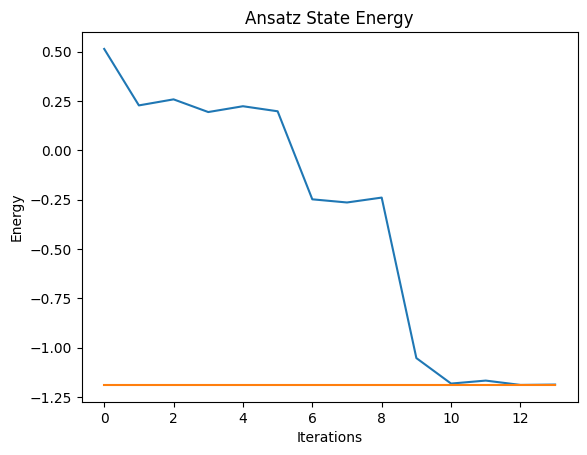

In [8]:
plt.plot(energies)
plt.plot(np.array(len(energies) * [ground_state_energy]))
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Ansatz State Energy")
plt.show()

### Convergence graph

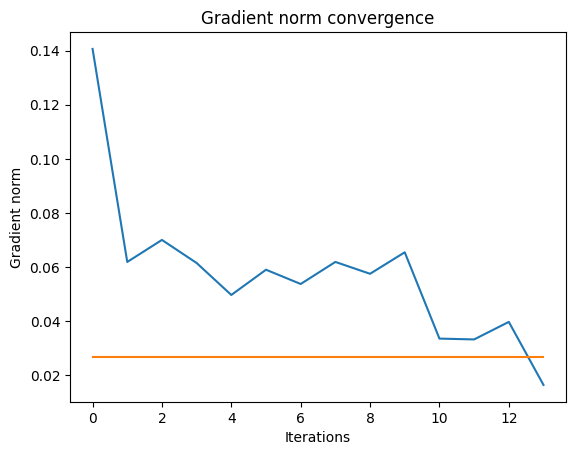

In [9]:
plt.plot(gradient_norms)
plt.plot(np.array(len(gradient_norms) * [tol]))
plt.xlabel("Iterations")
plt.ylabel("Gradient norm")
plt.title("Gradient norm convergence")
plt.show()

### Optimized State Ansatz

In [10]:
# optimized ground state energy
print(f"ADAPT-VQE minimal energy: {optimization_results[-1][0]}")

# optimized thetas (rounded)
optimized_thetas = [optimization_results[-1][1]["params"]][0]
rounded_thetas = [round(optimized_thetas[i], 3) for i in range(len(optimized_thetas))]
print(f"optimized thetas: {rounded_thetas}")

# total number of optimization parameters
K = len(optimized_thetas)
print(f"Total number of optimization parameters: {K}")

ADAPT-VQE minimal energy: -1.18779296875
optimized thetas: [0.943, -0.038, 0.341, 0.288, 0.597, 0.643, 0.79, 0.692, 0.628, 1.577, 0.574, 0.051, 0.66, 0.756]
Total number of optimization parameters: 14


In [1]:
# associated operators
# optimization_ops = [op_pool[idx] for idx in ansatz_ops_indicies]
# print(f"optimization operators: {optimization_ops}")

### Circuit Information

The circuit width and depth are:

In [12]:
# circuit width
print(f"circuit width: {qprog.data.width}")
# circuit depth
print(f"circuit depth: {qprog.transpiled_circuit.depth}")

circuit width: 4
circuit depth: 12


## Ansatz State Properties
The estimation of the observables is a stochastic process, leading to slightly varying results on each run of the notebook. The probabilistic nature of this process modifies both the final ansatz state and the convergence properties (number of iterations).

In the considered instance, an ansatz state with $14$ parameters converged to a result close to the true ground state energy. The ansatz operators, indexed by their associated index in the operator pool:
$[6,2,2,6,0,7,3,2,5,4,1,6,7]$.

The optimization parameters are: $$ \vec{\theta} = [0.943, -0.038, 0.341, 0.288, 0.597, 0.643, 0.79, 0.692, 0.628, 1.577, 0.574, 0.051, 0.66, 0.756]^T~~,$$ 

and minimal energy ($\langle\psi^{\text{ADAPT}}|H |\psi^{\text{ADAPT}}\rangle$): $-1.18779296875$

The ansatz state can be constructed with a quantum circuit with a circuit width of $4$ and circuit depth of $12$.

## Comparison to the VQE algorithm

We now validate the results of the ADAPT-VQE by comparing them to the outcome of the standard VQE algorithm, with the same number of optimization parameters, `K`. We fix the ansatz state by considering a product form of phases, $$|\psi_{\text{VQE}}\rangle = \Pi_{k=1}^{K} e^{-i \theta_k O_k}|0^n\rangle~~,$$ where $n=4$, for the presented test case. The operators $\{O_k\}$ are determined by their operator pool indices in `vqe_ansatz_ops_indicies` and the associated parameters $\{\theta_k\}$ are optimized by applying the VQE algorithm.


In [13]:
modular_range = [i + 2 % len(op_pool) for i in range(K - 1)]
modular_range = [0] + modular_range
vqe_ansatz_ops_indicies = modular_range


@qfunc
def main(params: CArray[CReal, K], v: Output[QArray[QBit, NUM_QUBITS]]):
    allocate(v)
    n = params.len
    adapt_vqe_ansatz(params, vqe_ansatz_ops_indicies, v)


qprog = synthesize(main)
write_qmod(main, name="vqe", decimal_precision=15, symbolic_only=False)


with ExecutionSession(qprog) as es:
    vqe_optimization_results = es.minimize(
        cost_function=HAMILTONIAN,  # Hamiltonian problem
        initial_params={"params": [0] * K},
        max_iteration=100,
    )

vqe_minimal_energy = vqe_optimization_results[-1][0]
print(f"VQE minimal energy: {vqe_minimal_energy}")

# optimized thetas (rounded)
vqe_optimized_thetas = [vqe_optimization_results[-1][1]["params"]][0]
vqe_rounded_thetas = [
    round(vqe_optimized_thetas[i], 3) for i in range(len(vqe_optimized_thetas))
]
print(f"VQE optimized thetas: {vqe_rounded_thetas}")

VQE minimal energy: -1.169921875
VQE optimized thetas: [0.093, 0.952, 0.396, 0.497, 1.329, -0.134, -0.917, -0.197, -0.701, 1.557, -0.92, 0.07, -0.031, -0.633]


### Circuit Information

In [14]:
# circuit width
print(f"circuit width: {qprog.data.width}")
# circuit depth
print(f"circuit depth: {qprog.transpiled_circuit.depth}")

circuit width: 4
circuit depth: 12


## Ansatz State Properties
The VQE ansatz is characterized by:

Optimized optimization parameters:  $$\vec{\theta} = [0.093, 0.952, 0.396, 0.497, 1.329, -0.134, -0.917, -0.197, -0.701, 1.557, -0.92, 0.07, -0.031, -0.633]^T$$

The ansatz operators are originally set (an arbitrary choice):  $[2,3,4,5,6,7,8,0,1,2,3,4,5,6]$.

and minimal energy $\langle\psi^{\text{VQE}}|H |\psi^{\text{VQE}}\rangle$: $-1.169921875$.

Similarly to the ADAPT-VQE ansatz state can be constructed with a quantum circuit with a circuit width of $4$ and circuit depth of $12$.

## Analysis and Summary

By comparing the results obtained with ADAPT-VQE, standard VQE, and exact diagonalization, we observe that for an equal number of variational parameters, ADAPT-VQE converges to an ansatz that yields a more accurate estimate of the ground-state energy, 
$E_{\text{g.s}}=  -1.189380715792109$. Specifically, ADAPT-VQE achieves an energy within approximately 
$~0.13$% of the exact value. In contrast, the VQE ansatz—whose operator structure is chosen independently of the Hamiltonian—converges to an optimal energy that remains $1.6$% above the true ground-state energy.

These results are consistent with the expected behavior of the two approaches. The ADAPT-VQE ansatz is constructed iteratively based on the energy gradient, which is directly determined by the Hamiltonian under consideration. As a consequence, only operators that most effectively lower the energy are included in the ansatz, leading to faster and more accurate convergence. This contrasts with a general, Hamiltonian-independent ansatz, which lacks such targeted optimization and therefore exhibits inferior convergence performance.

## References

<a id='ADAPT-VQE'>[1]</a>: [Grimsley, H. R., Economou, S. E., Barnes, E., & Mayhall, N. J. (2019). An adaptive variational algorithm for exact molecular simulations on a quantum computer. Nature communications, 10(1), 3007.](https://arxiv.org/abs/1812.11173)

<a id='VQE'>[2]</a>: [Tilly, J., Chen, H., Cao, S., Picozzi, D., Setia, K., Li, Y., ... & Tennyson, J. (2022). The variational quantum eigensolver: a review of methods and best practices. Physics Reports, 986, 1-128.](https://arxiv.org/abs/2111.05176)